# VCGC: Vertex Coloring with Grover's Circuit - G002
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

![G002](../data/networkx/g002.png)

### 1. Prepare the circuit and add the uniform state preparation operator. 

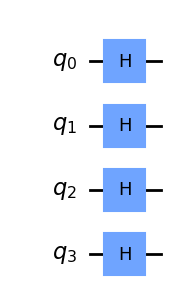

In [22]:
from qiskit import *

num_qubits = 4
# Subcircuit for uniform state preparation operator
state_prep_oracle= QuantumCircuit(num_qubits,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(num_qubits):
    state_prep_oracle.h(qubit)

state_prep_oracle.draw('mpl', style='clifford')

### 2. Using Tweedledum to convert the predicate function to quantum circuit

#### Regular Grover Oracle

In [23]:
# Create a quantum subcircuit for grover oracle
from tweedledum.synthesis import xag_synth  # Import XAG synthesis
from qiskit.circuit.classicalfunction.utils import tweedledum2qiskit
from qiskit.circuit.classicalfunction import ClassicalFunction
from tweedledum.qiskit import *
from qiskit.circuit.classicalfunction.types import Int1
from tweedledum.bool_function_compiler.bitvec import BitVec
from tweedledum.bool_function_compiler.bool_function import BoolFunction

def xag_synthesizer(cf):
    """Custom synthesizer using XAG synthesis instead of PKRM""" 

    # Get the LogicNetwork object from cf.network
    logic_network = cf._logic_network
    
    # Perform XAG synthesis ONCE and store the result
    tweedledum_circuit = xag_synth(logic_network)
    print(f"Number of qubits in Tweedledum circuit: {tweedledum_circuit.num_qubits()}")
    print(tweedledum_circuit)
    qc_qiskit = to_qiskit(tweedledum_circuit, circuit_type="gatelist")

    return qc_qiskit

Number of qubits in Tweedledum circuit: 10
                                                                           »
__a9 : ────────────────────────────────────────────────────────────────────»
                                                           ╭────╮          »
__a8 : ────────────────────────────────────────────────────┤ rx ├──────────»
                                                   ╭────╮  ╰─┬──╯          »
__a7 : ────────────────────────────────────────────┤ rx ├────●─────────────»
                                           ╭────╮  ╰─┬──╯    │             »
__a6 : ────────────────────────────────────┤ rx ├────●───────┼─────────────»
                      ╭────╮               ╰─┬──╯    │       │             »
__a5 : ───────────────┤ rx ├─────────────────┼───────●───────┼─────────────»
                      ╰─┬──╯                 │               │             »
__q4 : ─────────────────┼────────────────────┼───────────────┼─────────────»
                        │        

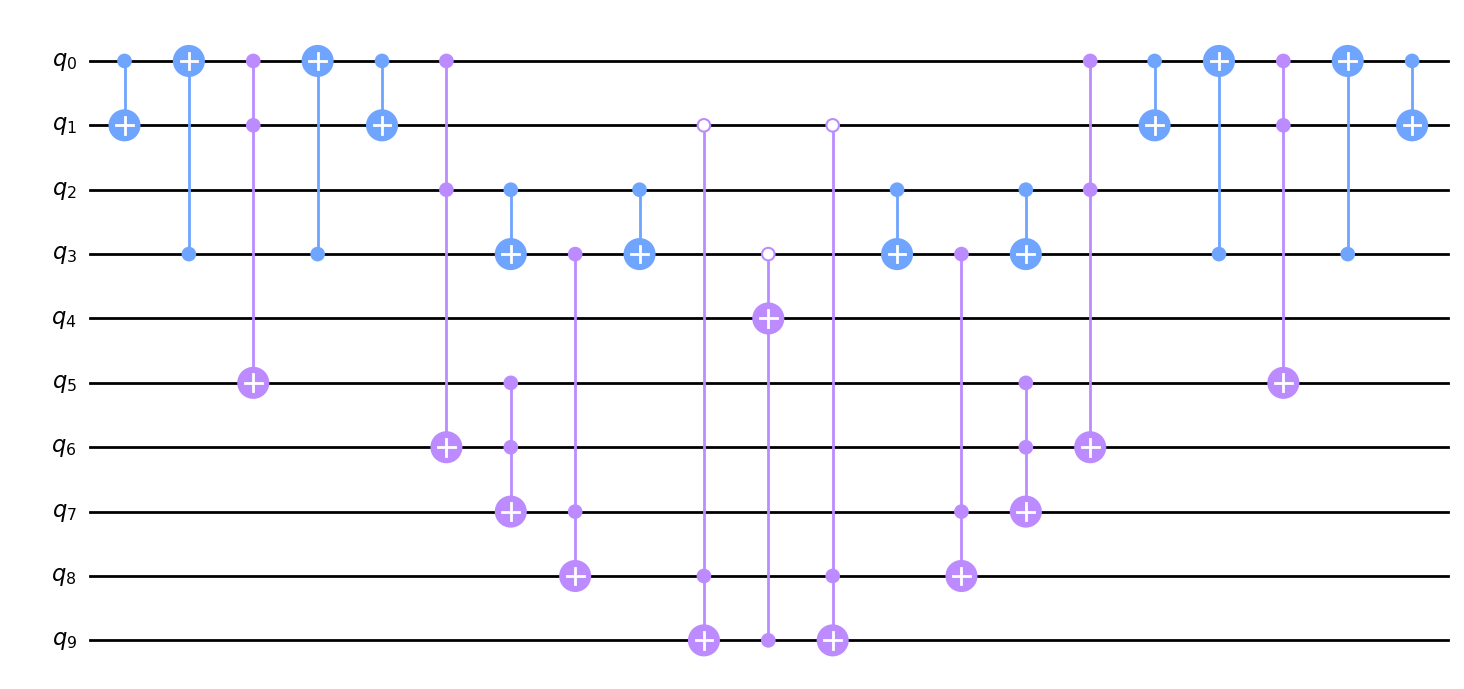

In [24]:

def grover_oracle_regular_func(v1: BitVec(1), v2: BitVec(1), v3: BitVec(1), v4: BitVec(1)) -> BitVec(1):
    c0 = v1 != BitVec(1,0)
    c1 = v3 != BitVec(1,0)
    c2 = (v1 != v2) and (v1 != v4)
    c3 = (v3 != v4)
    c4 = v2 != BitVec(1,1)
    c5 = v4 != BitVec(1,1)

    return c0 and c1 and c2 and c3 and c4 and c5

bf1 = BoolFunction(grover_oracle_regular_func)
grover_oracle_regular = xag_synthesizer(bf1)
grover_oracle_regular.name = "grover_oracle_regular_func"
print("Circuit Depth: " + str(grover_oracle_regular.depth()))
grover_oracle_regular.draw('mpl', style = 'clifford')

#### Inverted Grover Oracle

The supported style names are ``"iqp"`` (default), ``"iqp-dark"``, ``"clifford"``, ``"textbook"`` and ``"bw"``.

Number of qubits in Tweedledum circuit: 10
                                                                           »
__a9 : ────────────────────────────────────────────────────────────────────»
                                                           ╭────╮          »
__a8 : ────────────────────────────────────────────────────┤ rx ├──────────»
                                                   ╭────╮  ╰─┬──╯          »
__a7 : ────────────────────────────────────────────┤ rx ├────●─────────────»
                                           ╭────╮  ╰─┬──╯    │             »
__a6 : ────────────────────────────────────┤ rx ├────●───────┼─────────────»
                      ╭────╮               ╰─┬──╯    │       │             »
__a5 : ───────────────┤ rx ├─────────────────┼───────●───────┼─────────────»
                      ╰─┬──╯                 │               │             »
__q4 : ─────────────────┼────────────────────┼───────────────┼─────────────»
                        │        

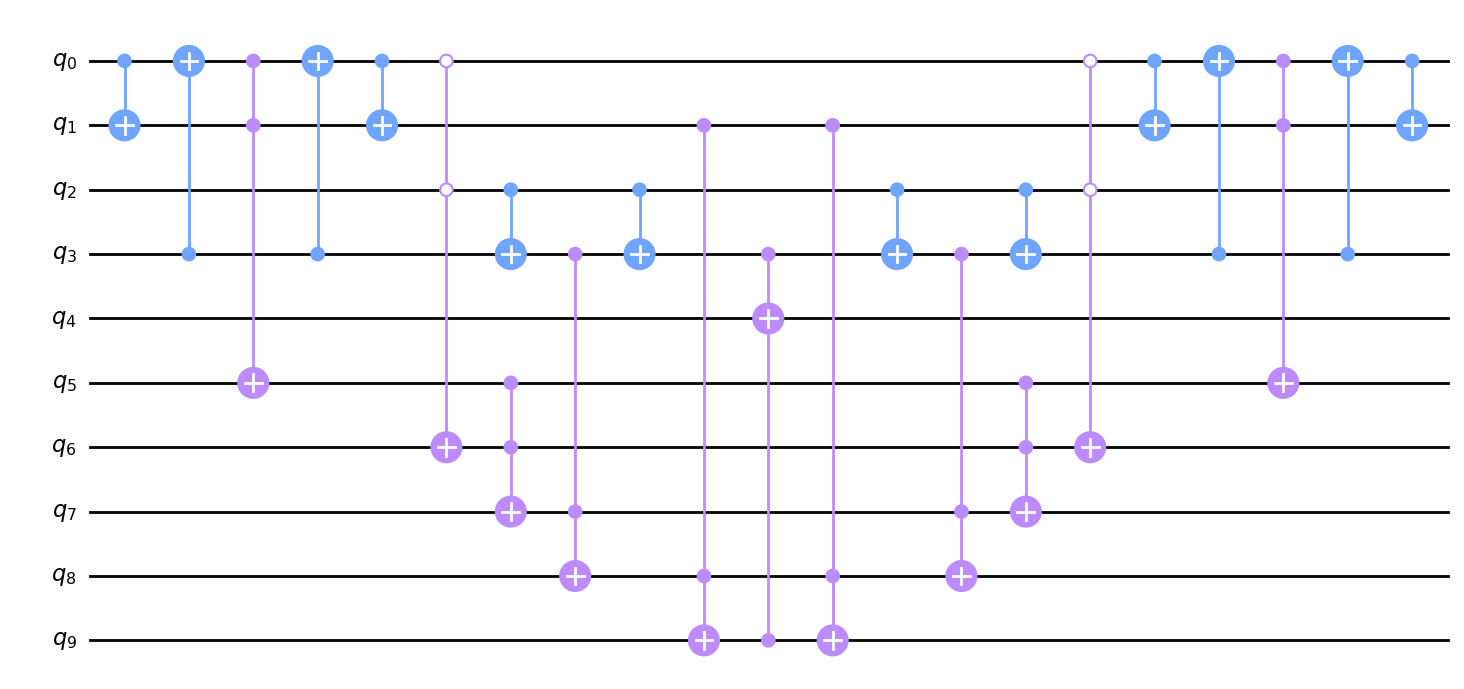

In [25]:
def grover_oracle_inverted_func(v1: BitVec(1), v2: BitVec(1), v3: BitVec(1), v4: BitVec(1)) -> BitVec(1):
    c0 = v1 != BitVec(1,1)
    c1 = v3 != BitVec(1,1)
    c2 = (v1 != v2) and (v1 != v4)
    c3 = (v3 != v4)
    c4 = v2 != BitVec(1,0)
    c5 = v4 != BitVec(1,0)

    return c0 and c1 and c2 and c3 and c4 and c5

bf2 = BoolFunction(grover_oracle_inverted_func)
grover_oracle_inverted = xag_synthesizer(bf2)
grover_oracle_inverted.name = "grover_oracle_inverted_func"
print("Circuit Depth: " + str(grover_oracle_inverted.depth()))
grover_oracle_inverted.draw('mpl', style='clifford')

Determining the number of qubits needed

In [26]:
num_qubits_oracle = grover_oracle_regular.num_qubits

### 3. Defining the diffusion operator

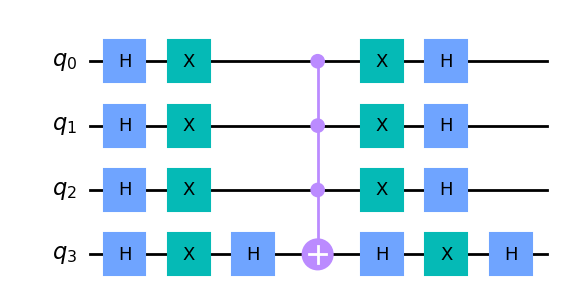

In [27]:
# Create a quantum subcircuit for grover diffusion operator
def create_grover_diffusion_operator(num_qubits):
    # Create a quantum subcircuit for grover diffusion operator
    grover_diff = QuantumCircuit(num_qubits, name="grover_diffusion")
    grover_diff.h(range(num_qubits))
    grover_diff.x(range(num_qubits))
    grover_diff.h(num_qubits - 1)
    grover_diff.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    grover_diff.h(num_qubits - 1)
    grover_diff.x(range(num_qubits))
    grover_diff.h(range(num_qubits))
    return grover_diff

grover_diffusion = create_grover_diffusion_operator(num_qubits)

grover_diffusion.draw('mpl',style='clifford')

### 4. Connect the whole circuit together

In [28]:
# Combining the subcircuits to form the complete Grover's algorithm
# Create a Quantum Circuit acting on a quantum register of 5 qubits

def prepare_circuit(qc: QuantumCircuit, num_qubits, num_qubits_oracle, state_prep: QuantumCircuit, grover_oracle: QuantumCircuit, grover_diff: QuantumCircuit, iterations: int = 1):
    qc.barrier()
    qc.x(num_qubits)
    qc.h(num_qubits)
    # Apply the state preparation operator
    qc.append(state_prep, list(range(num_qubits)))
    qc.barrier()
    for _ in range(iterations):
        # Apply the Grover oracle
        qc.append(grover_oracle, list(range(num_qubits_oracle)))
        qc.barrier()
        # Apply the Grover diffusion operator
        qc.append(grover_diff, list(range(num_qubits)))
        qc.barrier()
    

qc_regular = QuantumCircuit(num_qubits_oracle, num_qubits_oracle)
qc_inverted = QuantumCircuit(num_qubits_oracle, num_qubits_oracle)
prepare_circuit(qc_regular, num_qubits, num_qubits_oracle, state_prep_oracle, grover_oracle_regular, grover_diffusion)
prepare_circuit(qc_inverted, num_qubits, num_qubits_oracle, state_prep_oracle, grover_oracle_inverted, grover_diffusion)

#### Regular Circuit

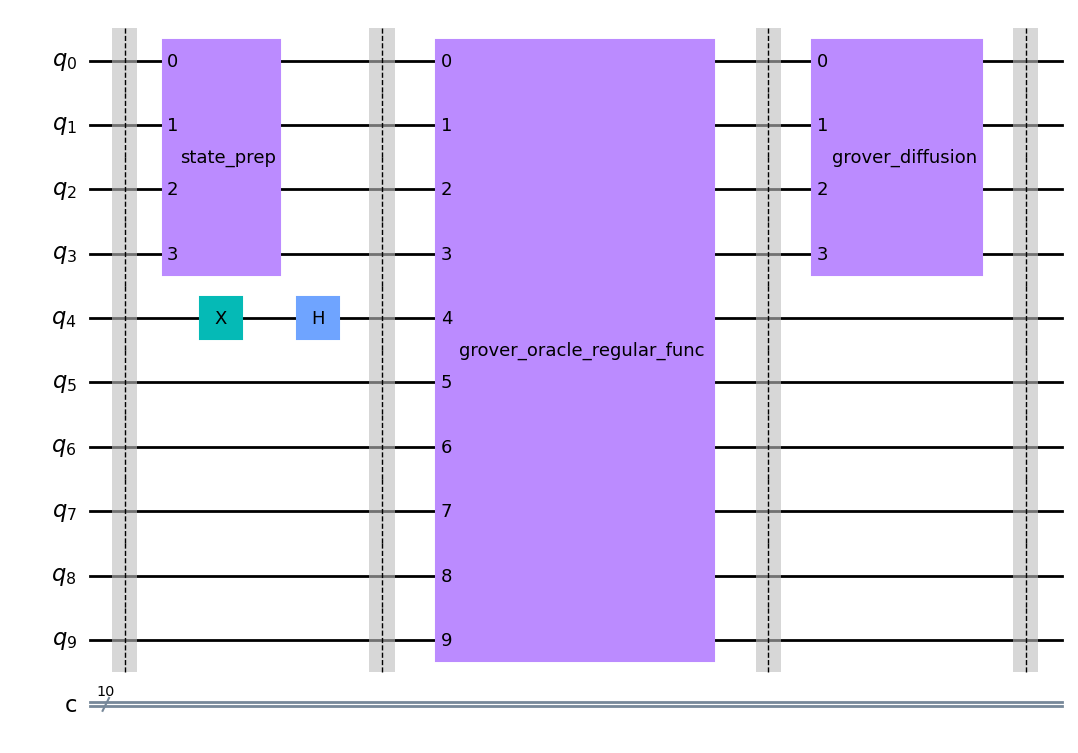

In [29]:

qc_regular.draw('mpl', style='clifford')

#### Inverted Circuit

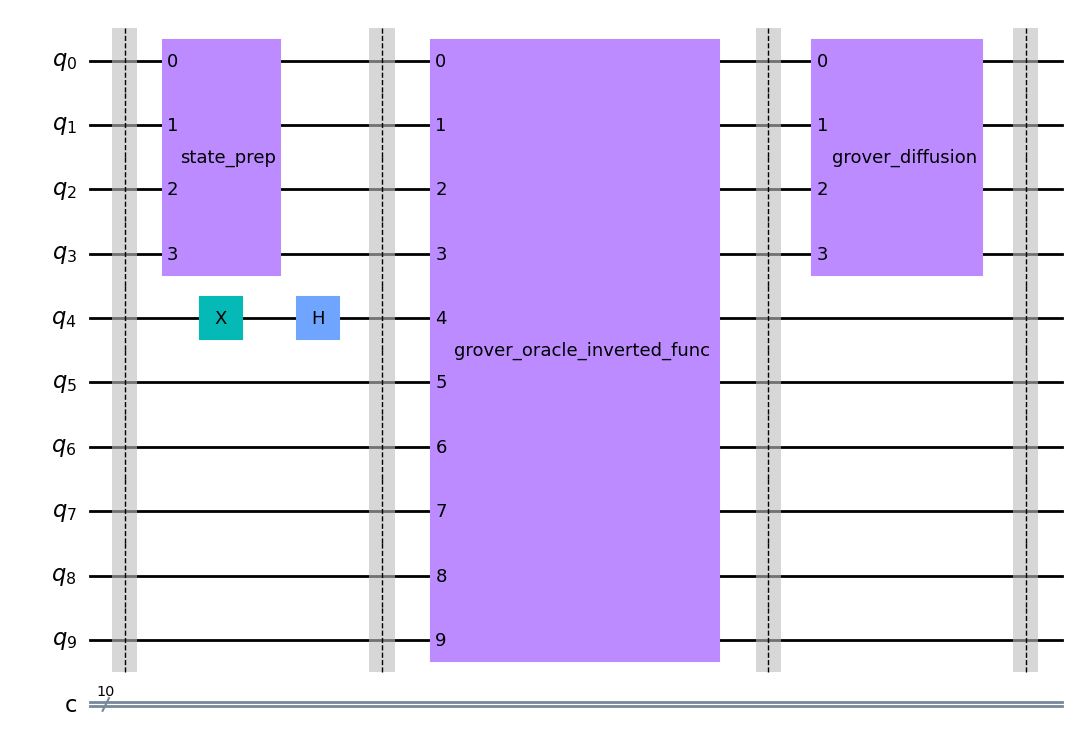

In [30]:
qc_inverted.draw('mpl', style='clifford')

### 5. Add measurements and decompose the circuits for the AER simulator

#### Regular Circuit

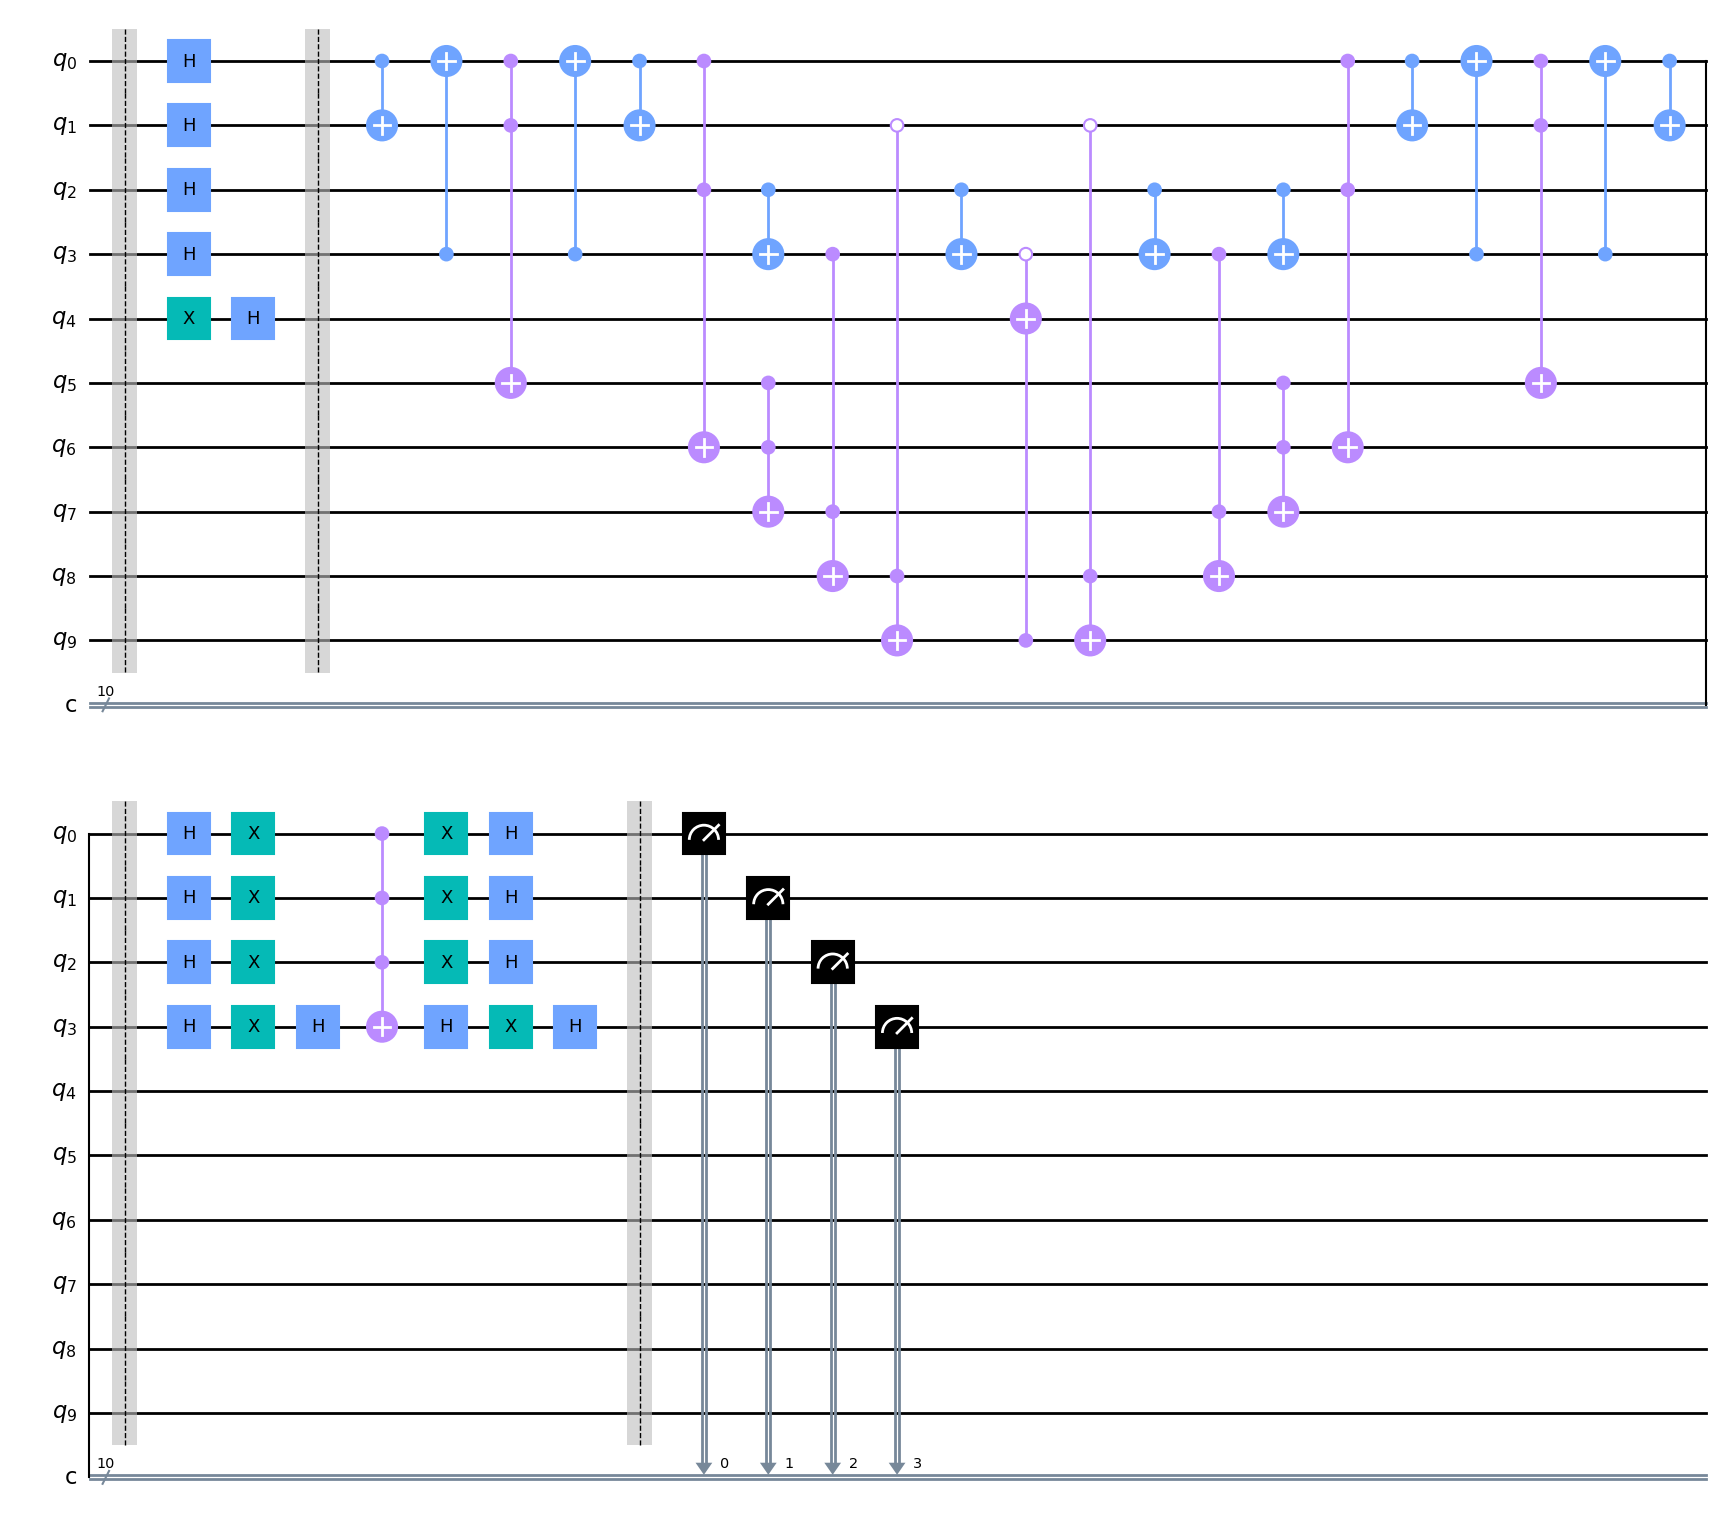

In [31]:
# qc_regular.measure_all(add_bits=False)
qc_regular.measure(list(range(num_qubits)), list(range(num_qubits))) # Measure the first 3 qubits
qc_decomposed_regular : QuantumCircuit = qc_regular.decompose(gates_to_decompose=["state_prep", "grover_oracle_regular_func", "grover_diffusion"])
qc_decomposed_regular.draw('mpl', style='clifford')


#### Inverted Circuit

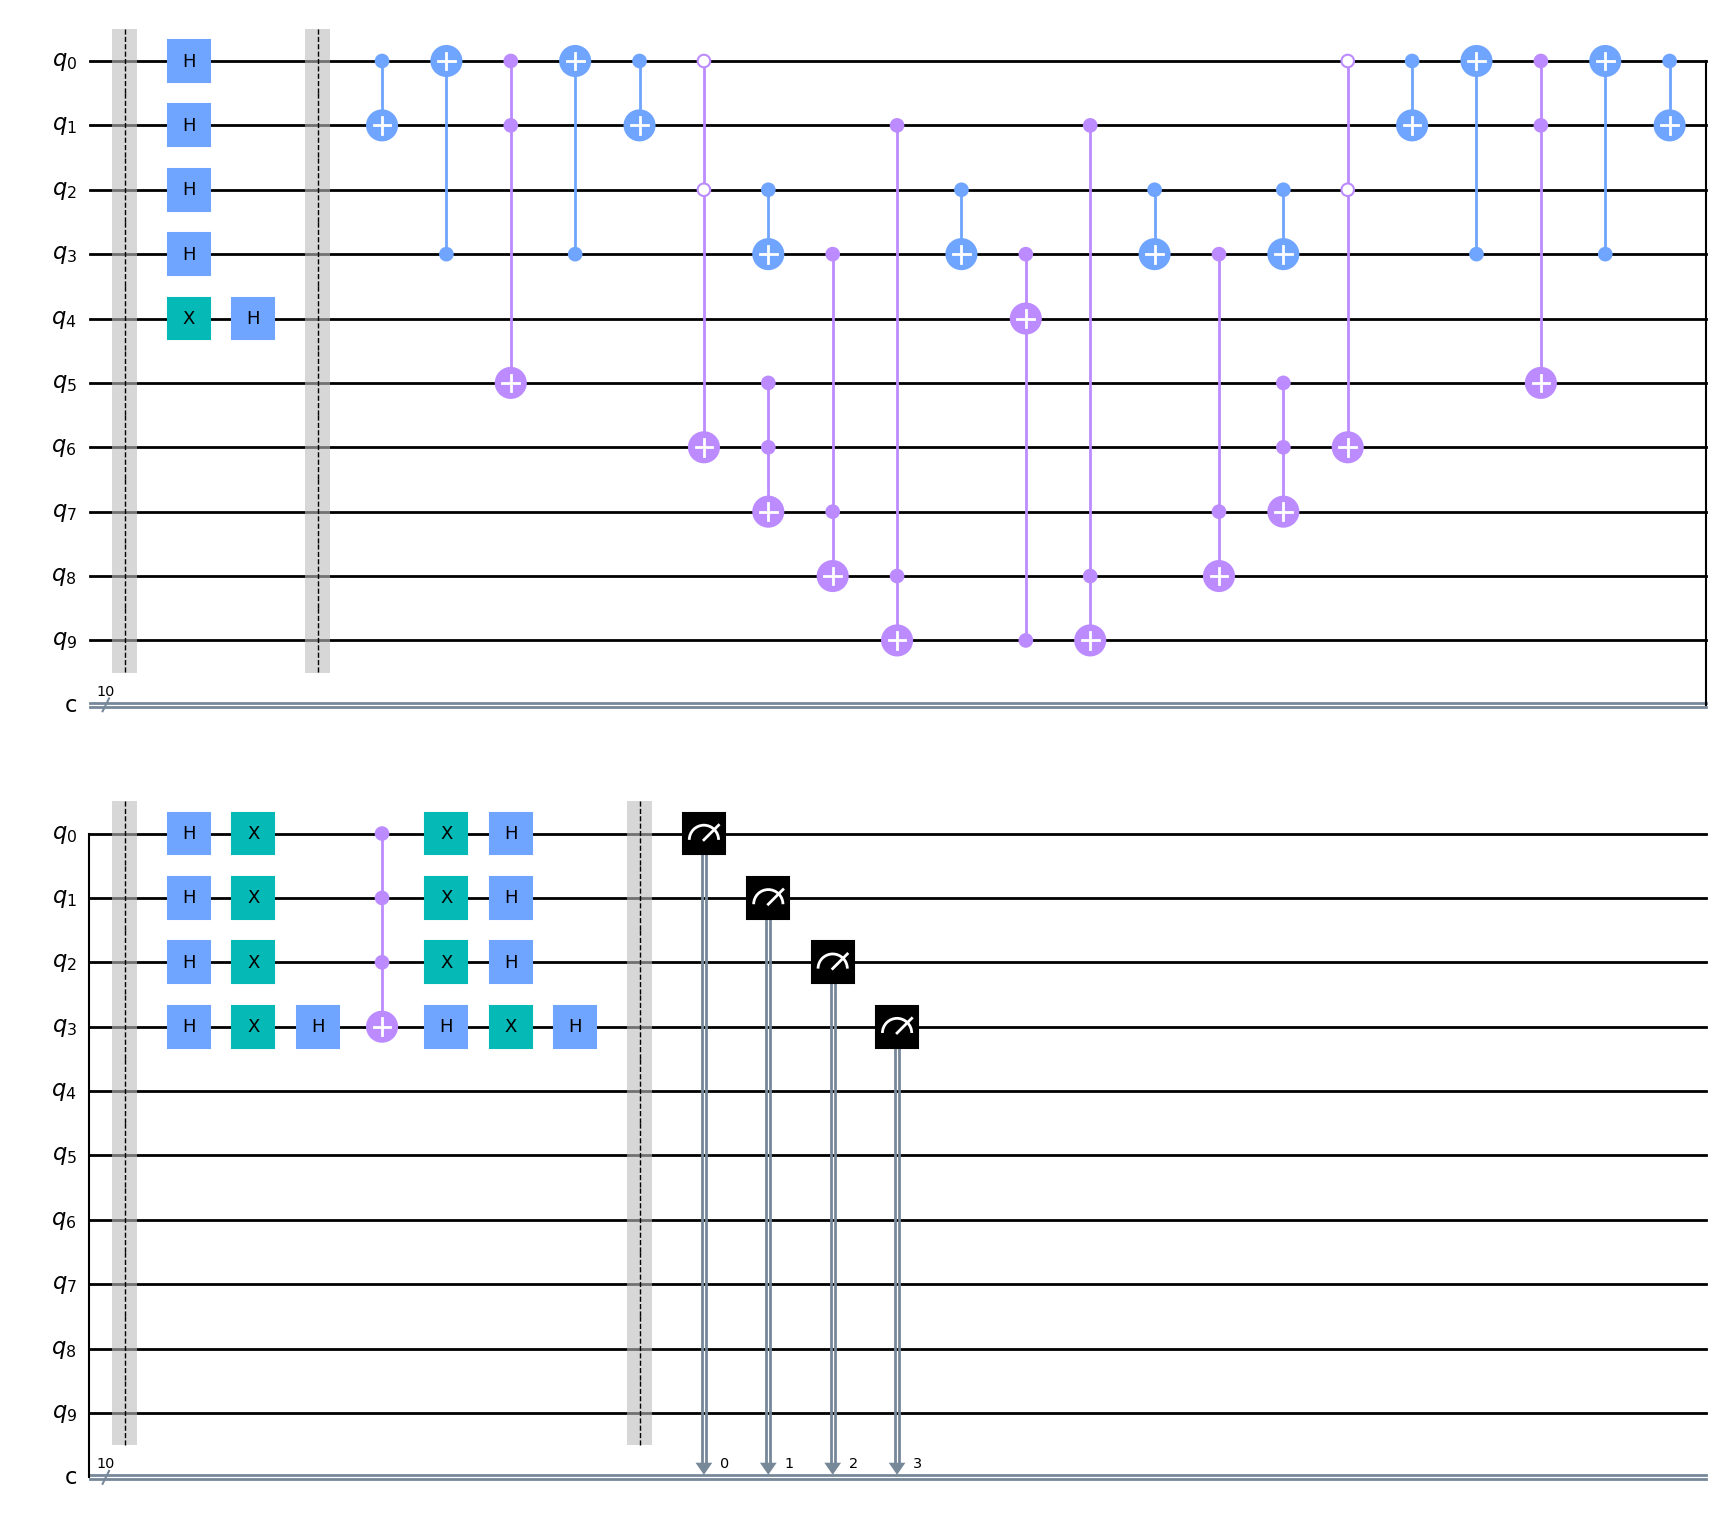

In [32]:
# qc_inverted.measure_all(add_bits=False)
qc_inverted.measure(list(range(num_qubits)), list(range(num_qubits))) # Measure the first 3 qubits
qc_decomposed_inverted : QuantumCircuit = qc_inverted.decompose(gates_to_decompose=["state_prep", "grover_oracle_inverted_func", "grover_diffusion"])
qc_decomposed_inverted.draw('mpl', style='clifford')

### 6. Run the circuits in the AER Simulator

##### Prepare the AER Simulator

In [33]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit import transpile
# Creating the backend
qasm_sim = Aer.get_backend('aer_simulator')

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

#### Regular Circuit

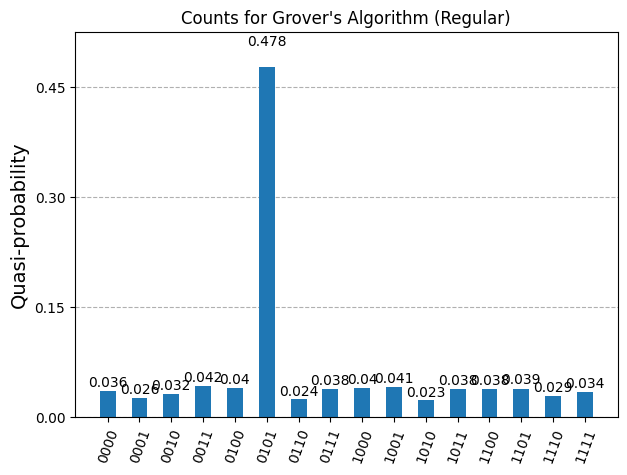

In [34]:
qc_decomposed_regular_transpiled = transpile(qc_decomposed_regular, backend=qasm_sim)
result_regular = qasm_sim.run(qc_decomposed_regular_transpiled).result()
counts_regular = result_regular.get_counts()
counts_regular_processed = process_counts(counts_regular, num_qubits=num_qubits)

plot_distribution(counts_regular_processed, title="Counts for Grover's Algorithm (Regular)")

#### Inverted Circuit

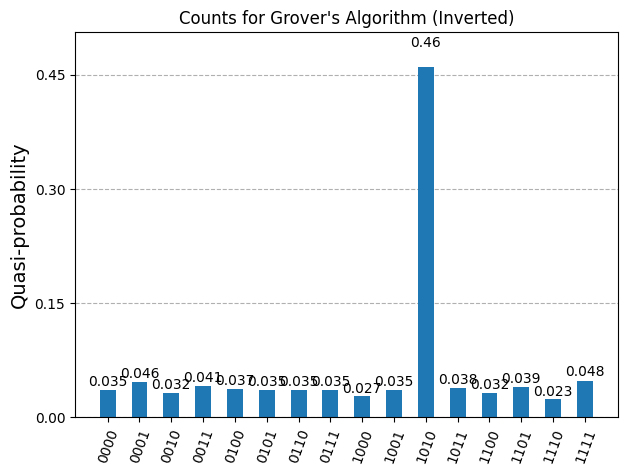

In [35]:
qc_decomposed_inverted_transpiled = transpile(qc_decomposed_inverted, backend=qasm_sim)
result_inverted = qasm_sim.run(qc_decomposed_inverted_transpiled).result()
counts_inverted = result_inverted.get_counts()
counts_inverted_processed = process_counts(counts_inverted, num_qubits=num_qubits)

plot_distribution(counts_inverted_processed, title="Counts for Grover's Algorithm (Inverted)")

### 7. Preparing Real IBM Quantum Device Backends

#### Getting a chosen backend and the least busy backend

In [36]:

# Run our circuit on the least busy backend. Transpiling before running.
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

least_busy_backend = service.least_busy(simulator=False, operational=True)
pick_backend = service.backend("ibm_brisbane")

least_busy_target = least_busy_backend.target
pick_target = pick_backend.target
print(f"Least busy backend: {least_busy_backend.name}")
print(f"The other backend: {pick_backend.name}")

Least busy backend: ibm_brisbane
The other backend: ibm_brisbane


#### Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [39]:
# from qiskit.transpiler import PassManager
# from qiskit.circuit.library import XGate
# from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations

# durations = DynamicCircuitInstructionDurations.from_backend(backend=least_busy_backend)
 
# optimized_pm = generate_preset_pass_manager(target=least_busy_target, optimization_level=3)
# dd_rep = 8
# dd_sequence = [XGate()] * dd_rep

# optimized_pm.scheduling = PassManager([
#     ALAPScheduleAnalysis(durations=durations),
#     PadDynamicalDecoupling(
#         durations=durations,
#         dd_sequences=dd_sequence,
#         pulse_alignment=16
#     )
# ])

# NUM_TRIAL = 10
# regular_transpiled_circuits = []
# inverted_transpiled_circuits = []
# for i in range(NUM_TRIAL):
#     regular_transpiled_circuits.append(optimized_pm.run(qc_regular))
#     inverted_transpiled_circuits.append(optimized_pm.run(qc_inverted))


# regular_depths = [circuit.depth() for circuit in regular_transpiled_circuits]
# inverted_depths = [circuit.depth() for circuit in inverted_transpiled_circuits]
# print("Regular Circuit Depths:")
# print(regular_depths)
# print("Inverted Circuit Depths:")
# print(inverted_depths)
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations

# First, get a basic transpilation without dynamic decoupling
optimized_pm_basic = generate_preset_pass_manager(target=least_busy_target, optimization_level=3)

# Try transpiling first to get mapped circuits
regular_transpiled_basic = optimized_pm_basic.run(qc_regular)
inverted_transpiled_basic = optimized_pm_basic.run(qc_inverted)

# Now apply dynamic decoupling only if needed
NUM_TRIAL = 10
regular_transpiled_circuits = []
inverted_transpiled_circuits = []

try:
    # Set up dynamic decoupling
    durations = DynamicCircuitInstructionDurations.from_backend(backend=least_busy_backend)
    dd_rep = 8
    dd_sequence = [XGate()] * dd_rep
    
    # Create a pass manager with dynamic decoupling
    dd_pm = PassManager([
        ALAPScheduleAnalysis(durations=durations),
        PadDynamicalDecoupling(
            durations=durations,
            dd_sequences=dd_sequence,
            pulse_alignment=16
        )
    ])
    
    # Apply to already transpiled circuits
    for i in range(NUM_TRIAL):
        # Clone the circuits first to avoid modifying the original
        reg_circuit = regular_transpiled_basic.copy()
        inv_circuit = inverted_transpiled_basic.copy()
        
        # Try to apply dynamic decoupling with error handling
        try:
            dd_pm.run(reg_circuit)
            regular_transpiled_circuits.append(reg_circuit)
        except Exception as e:
            print(f"Warning: Could not apply DD to regular circuit: {e}")
            regular_transpiled_circuits.append(reg_circuit)
            
        try:
            dd_pm.run(inv_circuit)
            inverted_transpiled_circuits.append(inv_circuit)
        except Exception as e:
            print(f"Warning: Could not apply DD to inverted circuit: {e}")
            inverted_transpiled_circuits.append(inv_circuit)
            
except Exception as e:
    print(f"Error setting up dynamic decoupling: {e}")
    # Fallback to basic transpilation if DD fails completely
    regular_transpiled_circuits = [regular_transpiled_basic] * NUM_TRIAL
    inverted_transpiled_circuits = [inverted_transpiled_basic] * NUM_TRIAL

# Continue with the analysis
regular_depths = [circuit.depth() for circuit in regular_transpiled_circuits]
inverted_depths = [circuit.depth() for circuit in inverted_transpiled_circuits]
print("Regular Circuit Depths:")
print(regular_depths)
print("Inverted Circuit Depths:")
print(inverted_depths)

Regular Circuit Depths:
[666, 666, 666, 666, 666, 666, 666, 666, 666, 666]
Inverted Circuit Depths:
[672, 672, 672, 672, 672, 672, 672, 672, 672, 672]


In [40]:

print("Regular Circuits Qubits:")
for circuit in regular_transpiled_circuits:
    print(circuit.layout.final_index_layout())
print("Inverted Circuits Qubits:")
for circuit in inverted_transpiled_circuits:
    print(circuit.layout.final_index_layout())


Regular Circuits Qubits:
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
[31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
Inverted Circuits Qubits:
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]
[17, 31, 29, 30, 13, 32, 36, 51, 12, 11]


In [41]:
regular_transpiled_circuit = regular_transpiled_circuits[0]
inverted_transpiled_circuit = inverted_transpiled_circuits[0]
used_qubits = list(set(regular_transpiled_circuit.layout.final_index_layout()).union(set(inverted_transpiled_circuit.layout.final_index_layout())))

# used_qubits = regular_transpiled_circuit.layout.final_index_layout()
used_qubits_regular = regular_transpiled_circuit.layout.final_index_layout()
used_qubits_inverted = inverted_transpiled_circuit.layout.final_index_layout()
print("Used Qubit for the Regular Circuit: " + str(used_qubits_regular))
print("Used Qubit for the Inverted Circuit: " + str(used_qubits_inverted))

Used Qubit for the Regular Circuit: [31, 29, 17, 30, 51, 28, 35, 47, 32, 36]
Used Qubit for the Inverted Circuit: [17, 31, 29, 30, 13, 32, 36, 51, 12, 11]


In [42]:
print(type(regular_transpiled_circuit.layout.final_index_layout()))
print(used_qubits)

<class 'list'>
[11, 12, 13, 17, 28, 29, 30, 31, 32, 35, 36, 47, 51]


### 8. Run the circuits in the least busy backend

#### Calibration Job

In [ ]:
import mthree
mit = mthree.M3Mitigation(least_busy_backend)
mit.cals_from_system(used_qubits)

/home/mael/Desktop/vcgc/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:863: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


[<RunningManJob('d1drta9v3z50008anrvg', backend='ibm_brisbane', mode_id=None)>]

#### Running the circuits

In [44]:
# Running the transpiled circuits using the sampler
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=least_busy_backend)
sampler.options.default_shots = 10_000
job = sampler.run([regular_transpiled_circuit, inverted_transpiled_circuit])

### $\color{yellow}{\text{9. Plot the results }}$

In [47]:
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=10>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=10000, num_bits=10>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-06-25 06:08:29', stop='2025-06-25 06:08:37', size=20000>)])}, 'version': 2})

#### Regular Circuit

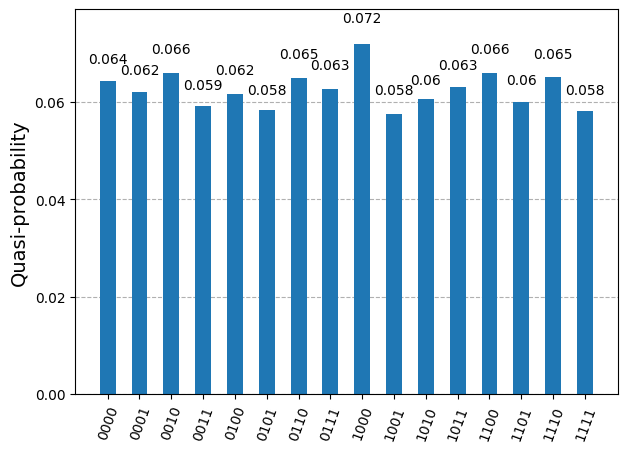

In [ ]:
from qiskit.visualization import plot_distribution
result = job.result()
regular_raw_counts = result[0].data.c.get_counts()
counts = process_counts(regular_raw_counts, num_qubits=num_qubits)
plot_distribution(counts)

#### Inverted Circuit

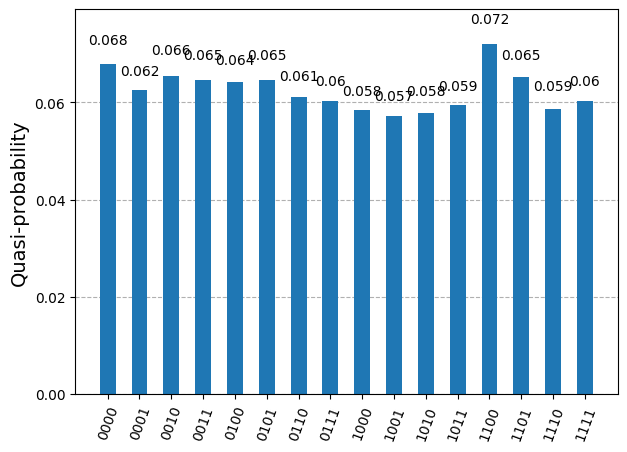

In [49]:
inverted_raw_counts = result[1].data.c.get_counts()
counts = process_counts(inverted_raw_counts, num_qubits=num_qubits)
plot_distribution(counts)

### $\color{orange}{\text{10. M3 Mitigation Correction}}$

#### Regular Circuit

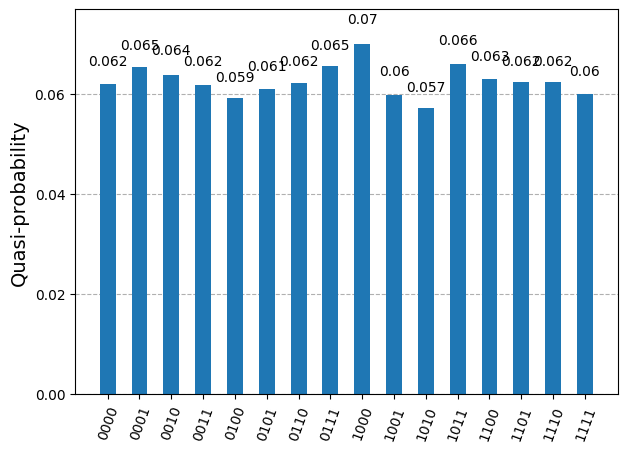

In [50]:
reg_quasi = mit.apply_correction(regular_raw_counts, used_qubits_regular)

mitigated_counts = {k: int(v*10_000) for k, v in reg_quasi.items()}

plot_distribution(process_counts(mitigated_counts, num_qubits))

#### Inverted Circuit

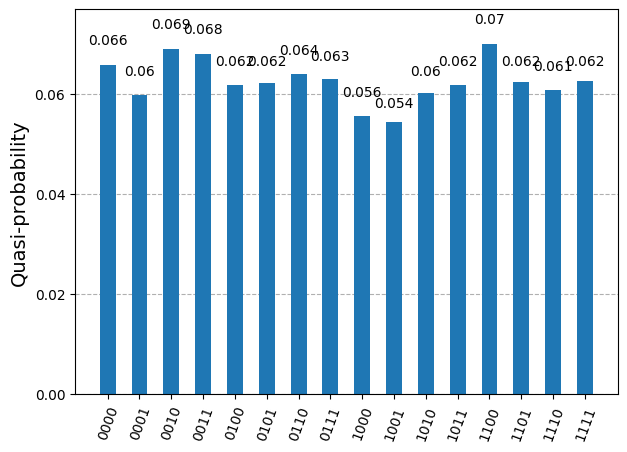

In [51]:
inverted_quasi = mit.apply_correction(inverted_raw_counts, used_qubits_inverted)

mitigated_counts = {k: int(v*10_000) for k, v in inverted_quasi.items()}

plot_distribution(process_counts(mitigated_counts, num_qubits))